pygame 2.5.2 (SDL 2.28.3, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html




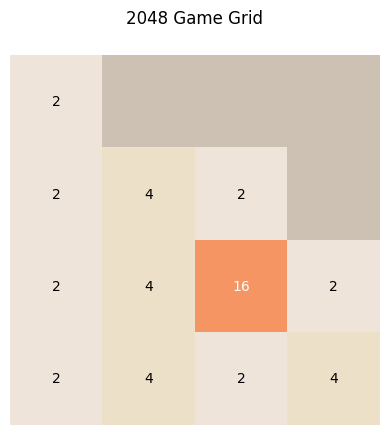

Model ./models\01_model.keras scored: 5956


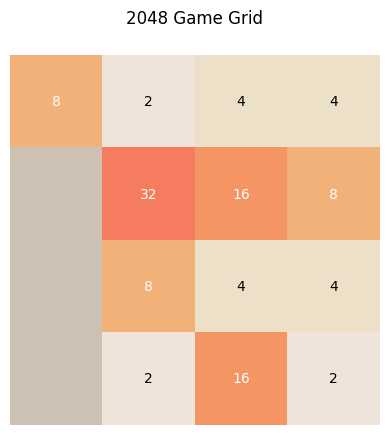

Model ./models\02_model.keras scored: 6397


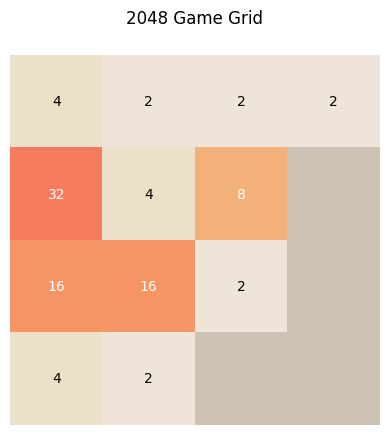

Model ./models\03_model.keras scored: 5877


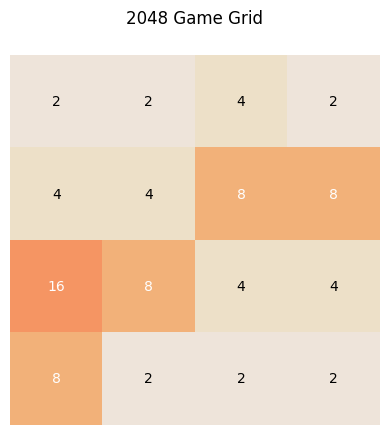

Model ./models\04_model.keras scored: 7804


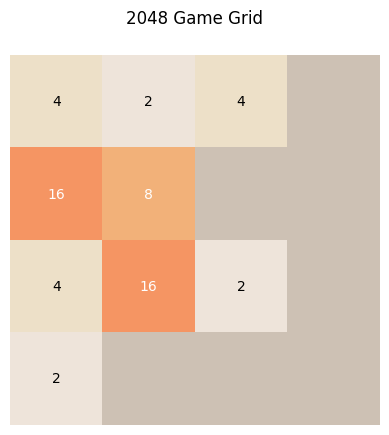

Model ./models\05_model.keras scored: 4549


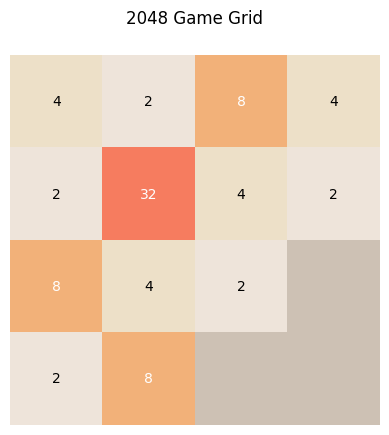

Model ./models\06_model.keras scored: 5913


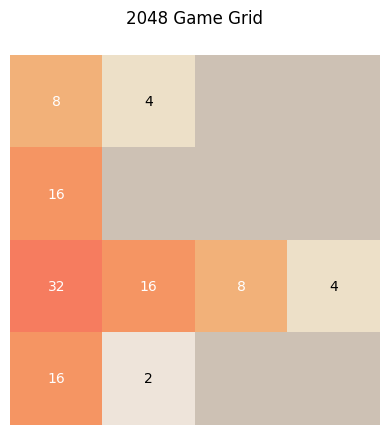

Model ./models\07_model.keras scored: 5593


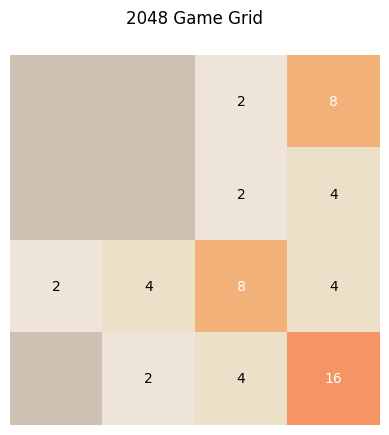

Model ./models\08_model.keras scored: 5435


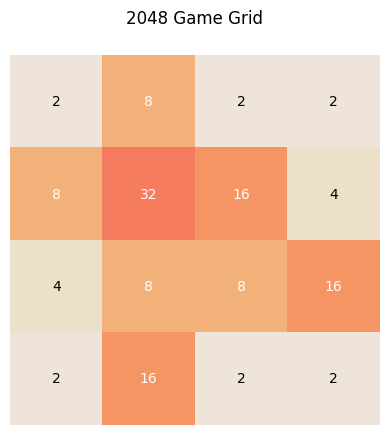

Model ./models\09_model.keras scored: 13841


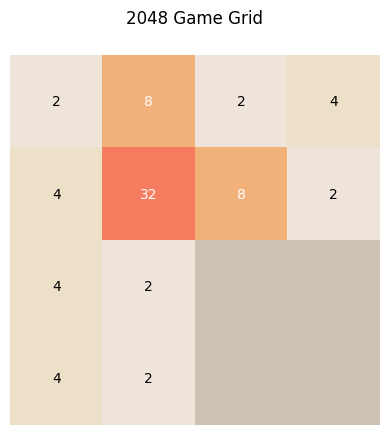

Model ./models\10_model.keras scored: 4334


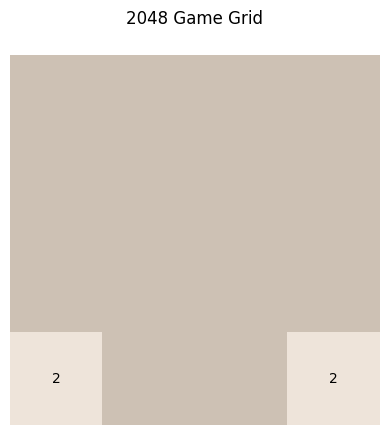

Model ./models\11_model.keras scored: 4503


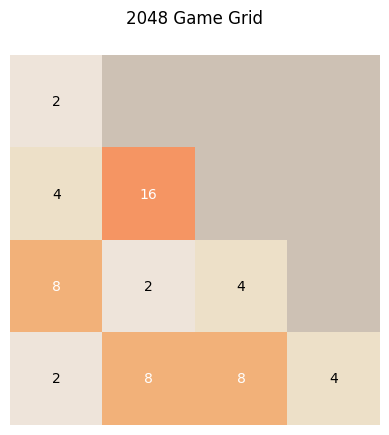

Model ./models\12_model.keras scored: 5284


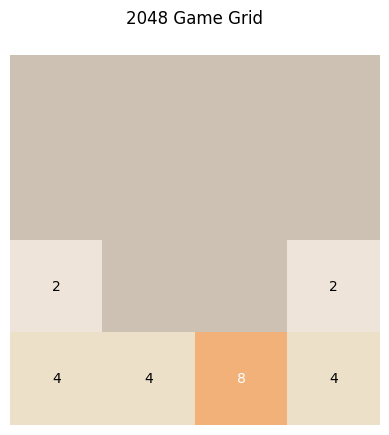

Model ./models\13_model.keras scored: 291


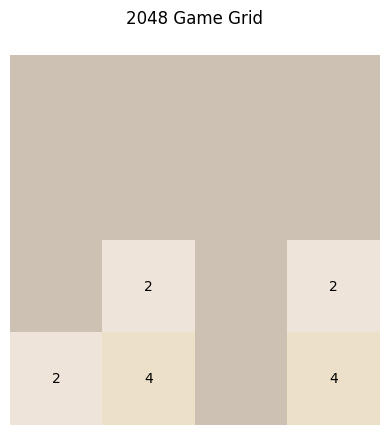

Model ./models\14_model.keras scored: 362


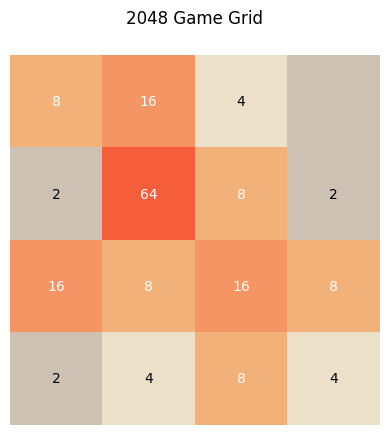

Model ./models\15_model.keras scored: 31323


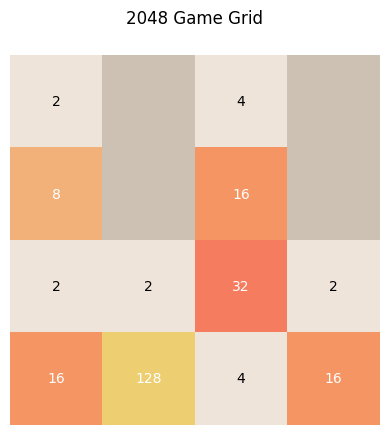

Model ./models\16_model.keras scored: 33450


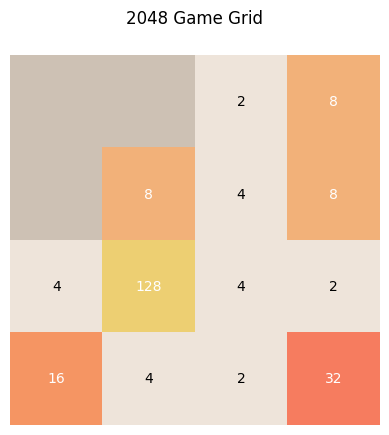

Model ./models\17_model.keras scored: 51465
Best model: ./models\17_model.keras with a score of 51465
{'./models\\01_model.keras': 5956, './models\\02_model.keras': 6397, './models\\03_model.keras': 5877, './models\\04_model.keras': 7804, './models\\05_model.keras': 4549, './models\\06_model.keras': 5913, './models\\07_model.keras': 5593, './models\\08_model.keras': 5435, './models\\09_model.keras': 13841, './models\\10_model.keras': 4334, './models\\11_model.keras': 4503, './models\\12_model.keras': 5284, './models\\13_model.keras': 291, './models\\14_model.keras': 362, './models\\15_model.keras': 31323, './models\\16_model.keras': 33450, './models\\17_model.keras': 51465}


In [1]:
import os
import sys
import pygame
import numpy as np
import random
import time
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib import colors

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Constants
BACKGROUND_COLOR = (187, 173, 160)
TEXT_COLOR = (119, 110, 101)
TILE_COLORS = {
    2: (238, 228, 218),
    4: (237, 224, 200),
    8: (242, 177, 121),
    16: (245, 149, 99),
    32: (246, 124, 95),
    64: (246, 94, 59),
    128: (237, 207, 114),
    256: (237, 204, 97),
    512: (237, 200, 80),
    1024: (237, 197, 63),
    2048: (237, 194, 46),
}
EMPTY_COLOR = (205, 192, 180)
TILE_SIZE = 100
TILE_MARGIN = 15
FONT_SIZE = 36
ACTION_MAP = {
    0: 'UP',
    1: 'DOWN',
    2: 'LEFT',
    3: 'RIGHT'
}

def init_grid():
    return np.zeros((4, 4), dtype=int)

def add_tile(grid):
    empty_cells = [(i, j) for i in range(4) for j in range(4) if grid[i][j] == 0]
    if empty_cells:
        i, j = random.choice(empty_cells)
        grid[i][j] = 2 if random.random() < 0.9 else 4
    return grid

def display_grid(grid):
    """
    Display a 2048 game grid using matplotlib.
    """
    color_map = colors.ListedColormap(['#CDC1B4', '#EEE4DA', '#EDE0C8', '#F2B179', '#F59563', 
                                       '#F67C5F', '#F65E3B', '#EDCF72', '#EDCC61', '#EDC850', '#EDC53F', '#EDC22E'])
    # Create an array where each cell is a power of 2: 2**1, 2**2, ..., 2**11, 2**12
    labels = grid
    labels[labels == 1] = 0  # replace 1 with 0 for empty cells as 2**0 is 1
    
    # Create discrete boundaries for the color map from 0 to max+1
    bounds = [0]+[2**i for i in range(1, 13)]
    norm = colors.BoundaryNorm(bounds, color_map.N)
    
    fig, ax = plt.subplots()
    mat = ax.matshow(labels, cmap=color_map, norm=norm)
    
    # Adding the numbers on the tiles
    for i in range(4):
        for j in range(4):
            c = labels[i, j]
            if c > 0:
                ax.text(j, i, str(int(c)), va='center', ha='center', color='black' if c < 8 else 'white')
    
    # Title and other formatting
    plt.title('2048 Game Grid')
    plt.axis('off')  # turn off the axis
    plt.show()

def draw_grid(screen, grid, score):
    screen.fill(BACKGROUND_COLOR)
    font = pygame.font.Font(None, FONT_SIZE)
    for i in range(4):
        for j in range(4):
            value = grid[i][j]
            color = TILE_COLORS.get(value, EMPTY_COLOR)
            pygame.draw.rect(screen, color, ((TILE_SIZE + TILE_MARGIN) * j + TILE_MARGIN,
                                             (TILE_SIZE + TILE_MARGIN) * i + TILE_MARGIN,
                                             TILE_SIZE, TILE_SIZE))
            if value:
                text_surface = font.render(f"{value}", True, TEXT_COLOR)
                text_rect = text_surface.get_rect(center=((TILE_SIZE + TILE_MARGIN) * j + TILE_MARGIN + TILE_SIZE // 2,
                                                          (TILE_SIZE + TILE_MARGIN) * i + TILE_MARGIN + TILE_SIZE // 2))
                screen.blit(text_surface, text_rect)
    score_text = font.render(f"Score: {score}", True, TEXT_COLOR)
    screen.blit(score_text, (20, 4 * (TILE_SIZE + TILE_MARGIN) + 20))
    pygame.display.update()

def compress(grid):
    new_grid = np.zeros((4, 4), dtype=int)
    done = False
    for i in range(4):
        count = 0
        for j in range(4):
            if grid[i][j] != 0:
                new_grid[i][count] = grid[i][j]
                if j != count:
                    done = True
                count += 1
    return new_grid, done

def merge(grid):
    done = False
    for i in range(4):
        for j in range(3):
            if grid[i][j] == grid[i][j + 1] and grid[i][j] != 0:
                grid[i][j] *= 2
                grid[i][j + 1] = 0
                done = True
    return grid, done

def reverse(grid):
    return np.fliplr(grid)

def transpose(grid):
    return np.transpose(grid)

def move(grid, direction):
    if direction == 'LEFT':
        grid, done = compress(grid)
        grid, temp = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
    elif direction == 'RIGHT':
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
    elif direction == 'UP':
        grid = transpose(grid)
        grid, done = compress(grid)
        grid, temp = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = transpose(grid)
    elif direction == 'DOWN':
        grid = transpose(grid)
        grid = reverse(grid)
        grid, done = compress(grid)
        grid, temp = merge(grid)
        done = done or temp
        grid, _ = compress(grid)
        grid = reverse(grid)
        grid = transpose(grid)
    return grid, done

def run_model_game(model_path):
    pygame.display.set_caption(f"2048 AI Game: {model_path}")
    
    model = load_model(model_path)
    score = 0

    for i in range(10):
        running = True
        moves = 0
        grid = init_grid()
        grid = add_tile(grid)
        prev_move = None
        while running:
            grid_input = grid.reshape(1, 4, 4, 1)
            predictions = model.predict(grid_input, verbose=0)
            action = np.argmax(predictions[0])
            grid, done = move(grid, ACTION_MAP[action])
            moves += 1
            if done:
                grid = add_tile(grid)
                score += np.sum(grid[grid >= 2] // 2)  # Simple scoring
            #if not prev_move == ACTION_MAP[action]:
            #    print(f'{ACTION_MAP[action]} score: {score} path: {model_path}')
            prev_move = ACTION_MAP[action]
    
            if moves > 100:
                running = False
    return score, grid

def main():
    model_dir = './models'
    model_files = [os.path.join(model_dir, f) for f in os.listdir(model_dir) if f.endswith('.keras')]
    
    scores = {}
    
    for model_path in model_files:
        score, grid = run_model_game(model_path)
        scores[model_path] = score
        display_grid(grid)
        print(f'Model {model_path} scored: {score}')
    
    best_model = max(scores, key=scores.get)
    print(f'Best model: {best_model} with a score of {scores[best_model]}')
    print(f'{scores}')

if __name__ == "__main__":
    main()